# **Brain Tumor Classification using CNN**
**Author:** Samay Asubadin  
**Degree:** Biomedical Engineering, Korea University  

This notebook presents the exploratory analysis, visualization, and qualitative evaluation
of a Convolutional Neural Network trained to classify brain MRI images into four categories:
glioma, meningioma, pituitary tumor, and non-tumor.

The core training and evaluation pipeline is implemented in `Brain_tumor_SamayAsubadin.py`.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [5]:
PROJECT_ROOT = os.getcwd()

DATASET_DIR = os.path.join(PROJECT_ROOT, "data")
TRAIN_DIR   = os.path.join(DATASET_DIR, "Train")
TEST_DIR    = os.path.join(DATASET_DIR, "Test")

MODEL_DIR  = os.path.join(PROJECT_ROOT, "models")
MODEL_PATH = os.path.join(MODEL_DIR, "brain_tumor_cnn_model.keras")

classes = ['glioma', 'meningioma', 'nontumor', 'pituitary']

In [27]:
from IPython.lib.display import isdir
counts = []
for cls in classes:
    path = os.path.join(TRAIN_DIR, cls)
    print(f"{cls}: {len(os.listdir(path))} images")
    if os.path.isdir(path) and not cls.startswith('.'):
        counts.append(len(os.listdir(path)))

glioma: 1321 images
meningioma: 1339 images
nontumor: 1595 images
pituitary: 1457 images


## **Class Distribution Visualization**

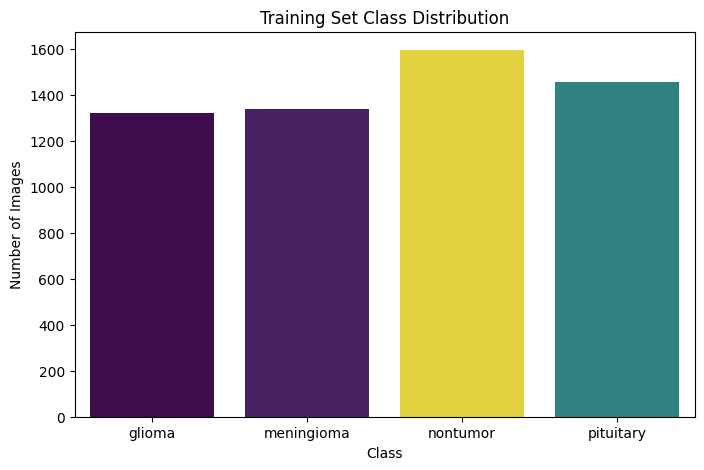

In [7]:
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes]

plt.figure(figsize=(8, 5))
sns.barplot(x=classes, y=class_counts, palette='viridis', hue=class_counts, legend=False)
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()

## **Visualizing Random Training Samples**
Ransom samples are visualized to qualitatively inspect image quality, contrast, and inter-class variability.

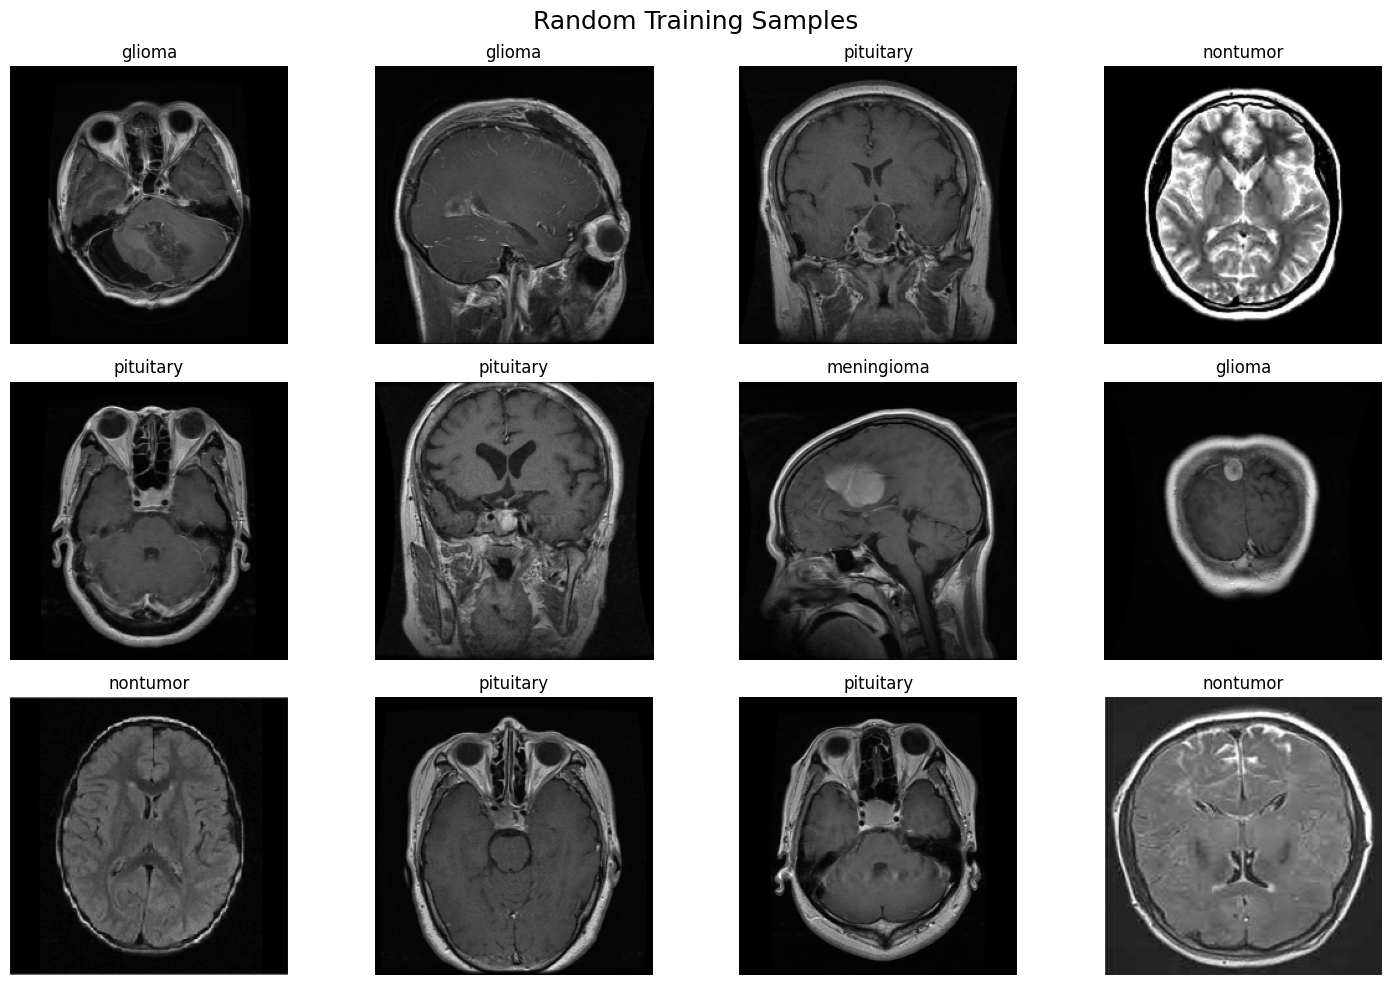

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Random Training Samples", fontsize=18)

for ax in axes.flatten():
    cls = random.choice(classes)
    img_name = random.choice(os.listdir(os.path.join(TRAIN_DIR, cls)))
    img_path = os.path.join(TRAIN_DIR, cls, img_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    ax.imshow(img, cmap='gray')
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
# Load Train model
model = load_model(MODEL_PATH)


##**Confusion Matrix**

In [28]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step


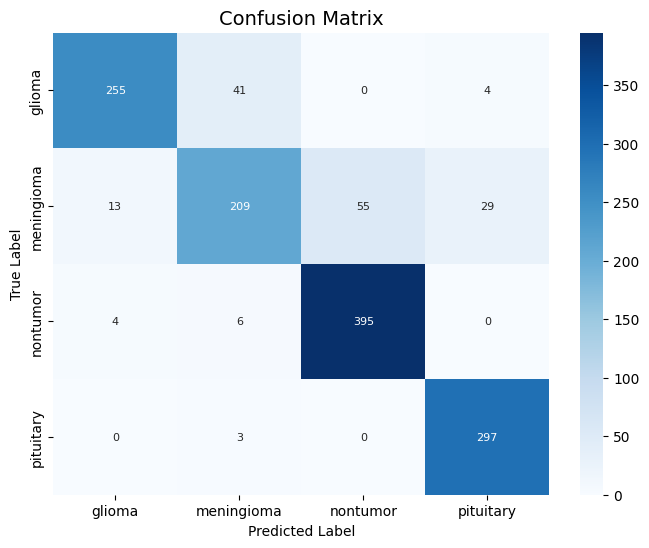

In [29]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes,
            annot_kws={"size": 8},
            cmap="Blues")

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

## **Predicted vs. Actual Image Classification**
This visualization highlights both correct and incorrect predictions,
providing insight into common failure modes and class-specific ambiguity.

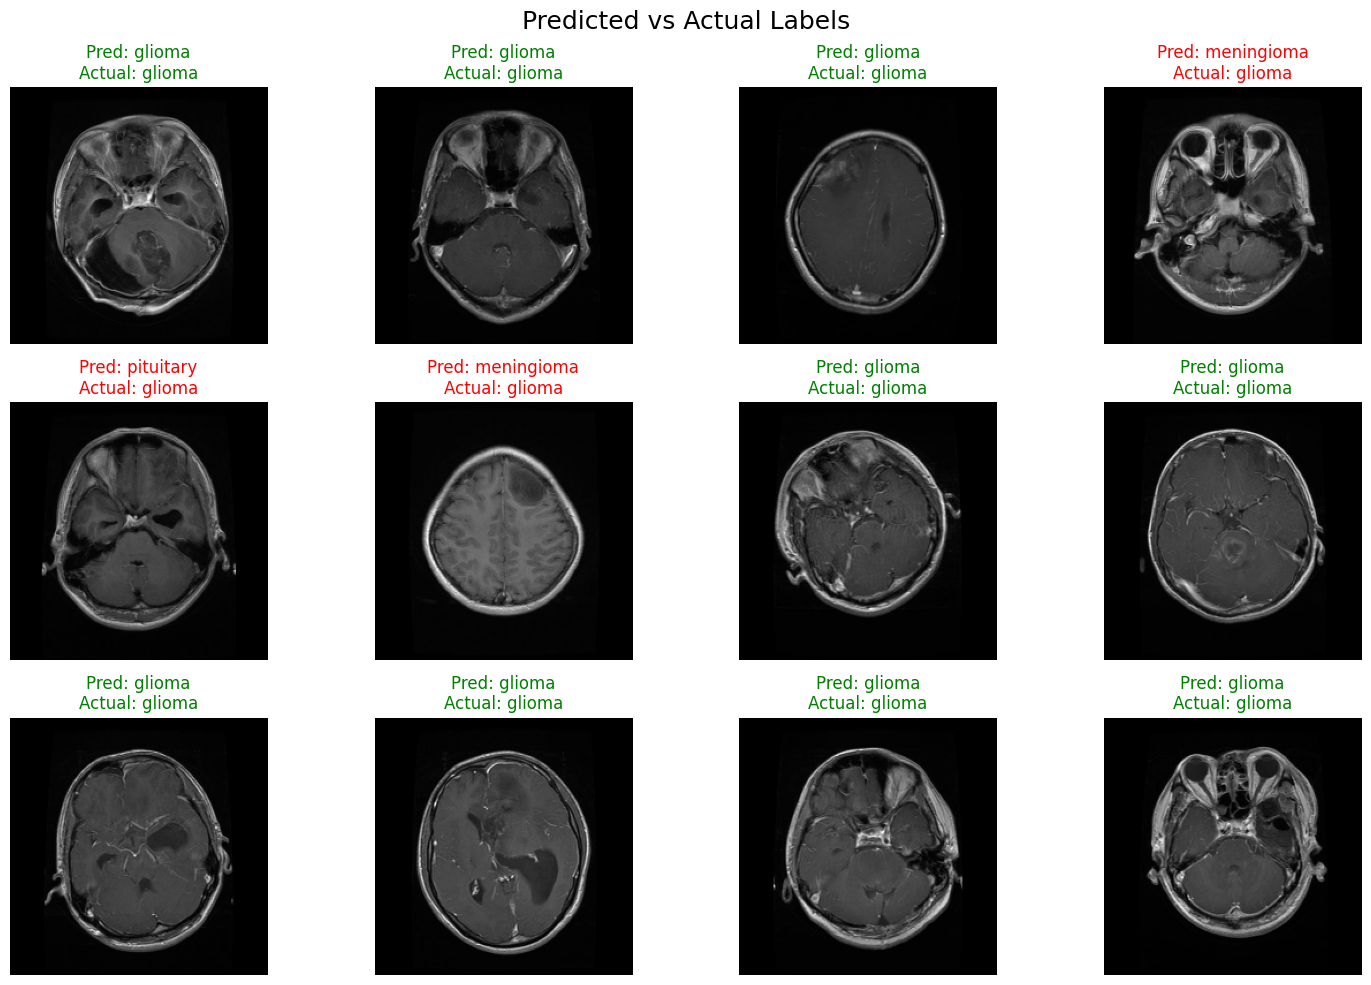

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Predicted vs Actual Labels", fontsize=18)

for i, ax in enumerate(axes.flatten()):
    img_path = test_gen.filepaths[i]
    true_label = classes[y_true[i]]
    pred_label = classes[y_pred[i]]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    color = "green" if true_label == pred_label else "red"

    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {pred_label}\nActual: {true_label}", color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Training Curves

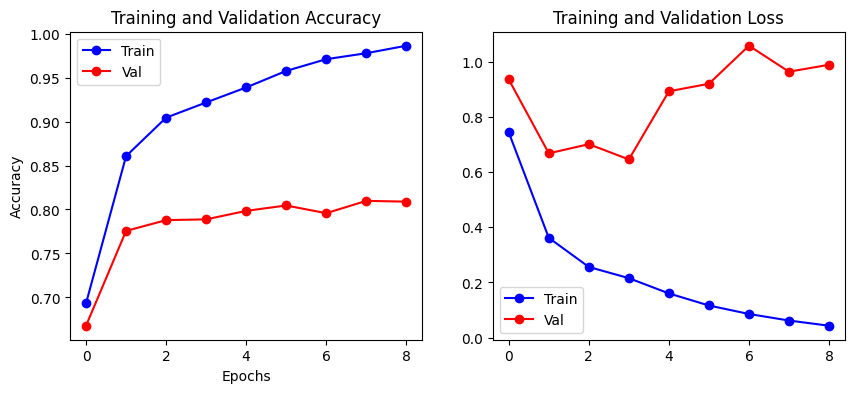

In [31]:
HISTORY_PATH = "models/training_history.npy"
history = np.load(HISTORY_PATH, allow_pickle=True).item()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], 'bo-', label='Train')
plt.plot(history['val_accuracy'], 'ro-', label='Val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], 'bo-', label='Train')
plt.plot(history['val_loss'], 'ro-', label='Val')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## **Interpretation**
The training set exhibits a moderately balanced class distribution across the four categories, with *nontumor* images being slightly more prevalent than tumor classes. While this imbalance is not extreme, it likely contributes to the model’s stronger performance on the nontumor class, as reflected in both the confusion matrix and the classification metrics.

Overall, the model achieves an accuracy of **88%** on the test set, indicating effective learning of discriminative features from brain MRI images. Performance varies across classes. *Pituitary* tumors and *nontumor* cases are classified with the highest reliability, achieving recall values of **0.99** and **0.98**, respectively. This suggests that these categories exhibit distinctive visual patterns that are well captured by the convolutional filters. In contrast, *meningioma* shows the weakest performance, with a recall of **0.68**, indicating that a substantial number of *meningioma* cases are misclassified.
The confusion matrix reveals that the most common errors occur between *glioma* and *meningioma*. This confusion is expected, as these tumor types often share overlapping morphological characteristics in MRI scans, such as similar intensity distributions and boundary textures. The training curves show a steady increase in training accuracy, reaching nearly **99%**, accompanied by a continuous decrease in training loss.

In contrast, validation accuracy plateaus around **80–82%**, while validation loss begins to increase after several epochs. This divergence indicates the onset of overfitting, where the model continues to improve on the training data but fails to generalize further to unseen samples. Although early stopping or stronger regularization could mitigate this behavior, the current model still maintains robust generalization performance, as evidenced by the strong weighted F1-score of **0.88**.